In [1]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline
import glob

# Camera Calibration

In [2]:
# establish the empty list to store image filenames
image_gray_list = []
image_list = []
filename_list = []

# Define numbers of corners in the chessboard
nx = 9
ny = 6

# The distortion correction key points
objpoints = [] # 3D points in real world space
imgpoints = [] # 2D points in image plane

# objp is always the meshgrid of the original corner numbers
objp = np.zeros((nx*ny,3), np.float32)
objp[:,:2] = np.mgrid[0:nx, 0:ny].T.reshape(-1,2) # x, y coordinates

# Read the image in the camera_cal directory
for filename in glob.glob('camera_cal/*.jpg'):
    filename_list.append(filename)
    # Read the image
    im = cv2.imread(filename)
    image_list.append(im)
    # Convert it to grayscale
    im_gray = cv2.cvtColor(im, cv2.COLOR_BGR2GRAY)
    # append it to the image list
    image_gray_list.append(im_gray)

# Fill in the distortion correction key points
for i in range(len(image_gray_list)):
    # Find the chessboard corners
    ret, corners = cv2.findChessboardCorners(image_gray_list[i], (nx,ny), None)
    # If corners are found, add object points, image points
    if ret == True:
        imgpoints.append(corners)
        objpoints.append(objp)
        ## img_corners = cv2.drawChessboardCorners(image_gray_list[i], (nx,ny), corners, ret)
        ## plt.figure()
        ## plt.title(filename_list[i])
        ## plt.imshow(img_corners,cmap='gray')
        ## plt.axis('off')


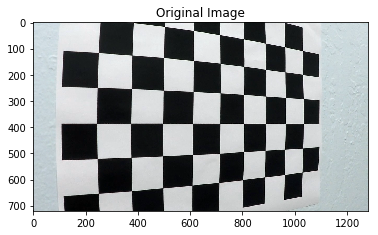

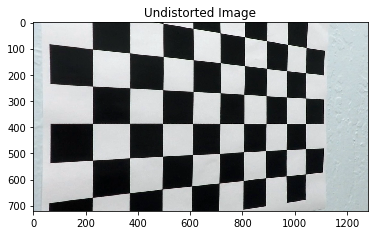

In [3]:
# Distortion correction function
def cal_undistort(img, objpoints, imgpoints):
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, gray.shape[::-1], None, None)
    undst = cv2.undistort(img, mtx, dist, None, mtx)
    return undst, mtx, dist, rvecs, tvecs

# Show an example of original image and undistorted image
undst, mtx, dist, rvecs, tvecs = cal_undistort(image_list[15], objpoints, imgpoints)
plt.figure()
plt.title('Original Image')
plt.imshow(image_list[15])
plt.figure()
plt.title('Undistorted Image')
plt.imshow(undst)
image_shape = image_gray_list[1].shape[::-1]

## Color/Gradient Threshold 

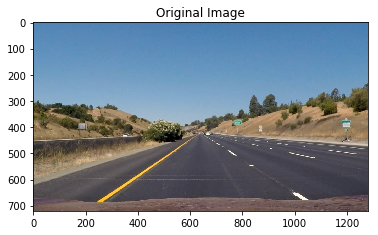

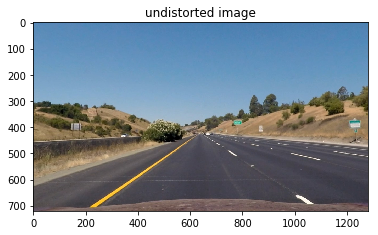

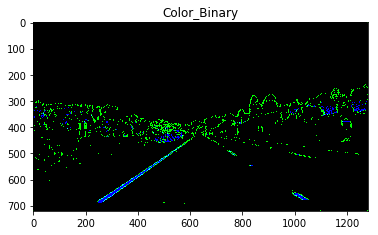

In [4]:
# Read a straight line image
image = cv2.imread('test_images/straight_lines1.jpg')

# Plot the original figure
ori_img = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
plt.imshow(ori_img)
plt.title('Original Image')
# Define threshold on S-channel
s_thresh = (150,255)

# Define threshold on sobel_x channel
sx_thresh = (33,150)
plt.figure()
undistort_img = cv2.undistort(image, mtx, dist, None, mtx)
undistort_image_show = np.copy(undistort_img)
plt.imshow(cv2.cvtColor(undistort_image_show, cv2.COLOR_BGR2RGB))
plt.title('undistorted image')
def thsd_enfs_pipeline(image, s_thresh, sx_thresh, mtx, dist):
    img = np.copy(image)
    undistort_img = cv2.undistort(image, mtx, dist, None, mtx)
    # Convert to HSV color space and separate the V channel
    hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HLS).astype(np.float)
    l_channel = hsv[:,:,1]
    s_channel = hsv[:,:,2]
    """ 
    ## Channel Image examples
    h_channel = hsv[:,:,0]
    plt.imshow(l_channel, cmap='gray')
    plt.title('l_channel')
    plt.figure()
    plt.imshow(s_channel, cmap='gray')
    plt.title('s_channel')
    plt.figure()
    plt.imshow(h_channel, cmap='gray')
    plt.title('h_channel')"""
    
    # Sobel_x & Sobel_y
    sobelx = cv2.Sobel(l_channel, cv2.CV_64F, 1, 0, ksize = 5) # Take the derivative in x
    sobely = cv2.Sobel(l_channel, cv2.CV_64F, 0, 1)
    abs_sobelx = np.absolute(sobelx)
    abs_sobely = np.absolute(sobely)
    scaled_sobelx = np.uint8(255*abs_sobelx/np.max(abs_sobelx))
    scaled_sobely = np.uint8(255*abs_sobely/np.max(abs_sobely))
    
    # Threshold x gradient
    sxbinary = np.zeros_like(scaled_sobelx)
    sxbinary[(scaled_sobelx >= sx_thresh[0]) & (scaled_sobelx <= sx_thresh[1])] = 1
    
    # Threshold color channel
    s_binary = np.zeros_like(s_channel)
    s_binary[(s_channel >= s_thresh[0]) & (s_channel <= s_thresh[1])] = 1
    
    # Stack each channel
    color_binary = np.dstack((np.zeros_like(sxbinary), sxbinary, s_binary))
    
    return color_binary
color_binary = thsd_enfs_pipeline(image, s_thresh, sx_thresh, mtx, dist)
plt.figure()
plt.imshow(color_binary)
plt.title('Color_Binary')

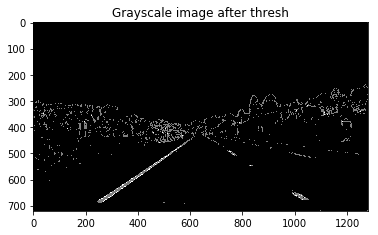

In [5]:
# Show the threshold-image in grayscale
plt.imshow(color_binary[:,:,2]+color_binary[:,:,1], cmap = 'gray')
plt.title('Grayscale image after thresh')

## Perspective Transform

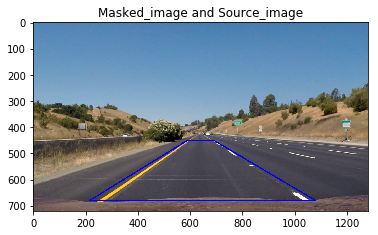

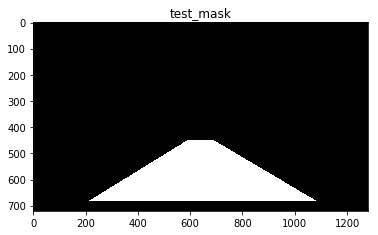

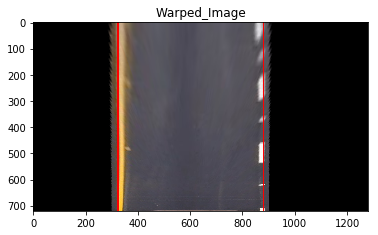

In [6]:
# Define a function perform perspective transform
imshape = image.shape
img_size = (image.shape[1], image.shape[0])
x1 = 215
y1 = 680
x2 = 590
y2 = 450
x3 = 690
y3 = 450
x4 = 1080
y4 = 680
offset = 200

# Draw the mask on the image
def mask(image,x1,x2,x3,x4,y1,y2,y3,y4):
    mask_image = np.copy(image)
    cv2.line(mask_image, (x1,y1), (x2, y2), [255, 0, 0], 3)
    cv2.line(mask_image, (x2, y2), (x3, y3), [255, 0, 0], 3)
    cv2.line(mask_image, (x3, y3), (x4, y4), [255, 0, 0], 3)
    cv2.line(mask_image, (x1, y1),(x4, y4), [255, 0, 0], 3)
    return mask_image

# Filter through the region of interest
def region_of_interest(img, vertices):
    """
    Applies an image mask.
    
    Only keeps the region of the image defined by the polygon
    formed from `vertices`. The rest of the image is set to black.
    """
    #defining a blank mask to start with
    mask = np.zeros_like(img)
    #defining a 3 channel or 1 channel color to fill the mask with depending on the input image
    if len(img.shape) > 2:
        channel_count = img.shape[2]  # i.e. 3 or 4 depending on your image
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255
    #filling pixels inside the polygon defined by "vertices" with the fill color    
    cv2.fillPoly(mask, vertices, ignore_mask_color)
    
    #returning the image only where mask pixels are nonzero
    plt.figure()
    plt.title('test_mask')
    plt.imshow(mask,cmap='gray')
    masked_image = cv2.bitwise_and(img, mask)
    return masked_image


mask_draw_image = mask(image,x1,x2,x3,x4,y1,y2,y3,y4)
plt.imshow(cv2.cvtColor(mask_draw_image,cv2.COLOR_BGR2RGB))
plt.title("Masked_image and Source_image")
src = np.float32([(x1,y1), (x2,y2), (x3,y3), (x4,y4)])

vertices = np.array([[(x1,y1), (x2,y2), (x3,y3), (x4,y4)]], dtype=np.int32)
masked_image = region_of_interest(image, vertices)
def pers_trans(image, src, offset, img_size):
        dst = np.float32([[300, img_size[1]],[300, 0], [900, 0], [900, img_size[1]]])
        # Given src and dst points, calculate the perspective transform matrix
        M = cv2.getPerspectiveTransform(src, dst)
        # Warp the image using OpenCV warpPerspective()
        warped = cv2.warpPerspective(image, M, img_size)
        # Return the resulting image and matrix
        return warped, M

warped_image, M = pers_trans(masked_image, src, offset, img_size)
cv2.line(warped_image, (300+25,img_size[1]), (300+25, 0), [0, 0, 255], 5)
cv2.line(warped_image, (900-20, img_size[1]), (900-20, 0), [0, 0, 255], 5)
plt.figure()
warped_image = cv2.cvtColor(warped_image, cv2.COLOR_BGR2RGB)
plt.imshow(warped_image)
plt.title('Warped_Image')

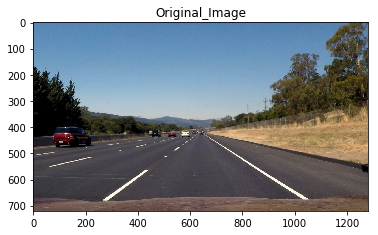

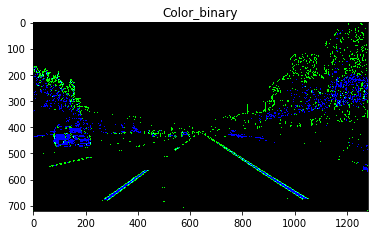

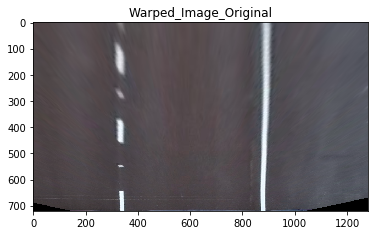

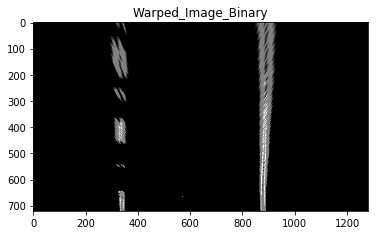

In [7]:
# Show a curved lane image and its warped version
input_image = 'straight_lines2'
image = cv2.imread('test_images/'+input_image+'.jpg')
image_copy = np.copy(image)
plt.figure()
plt.imshow(cv2.cvtColor(image_copy,cv2.COLOR_BGR2RGB))
plt.title('Original_Image')

color_binary = thsd_enfs_pipeline(image, s_thresh, sx_thresh, mtx, dist)
plt.figure()
plt.imshow(color_binary)
plt.title('Color_binary')
warped_image_binary, M = pers_trans(color_binary, src, offset, img_size)
warped_image_original, M = pers_trans(image_copy, src, offset, img_size)

warped_image_binary = warped_image_binary[:,:,1]+warped_image_binary[:,:,2]
"""
# Apply the mask on the edge image
vertices = np.array([[(200,imshape[1]), (200,0), (1150,0), (1150,imshape[1])]], dtype=np.int32)
warped_image_original = region_of_interest(warped_image_original, vertices)
warped_image_binary = region_of_interest(warped_image_binary[:,:,1]+warped_image_binary[:,:,2], vertices)
 """
# Mask out the region on the left and right edges of image. Assume the vehicle keeps
# driving around the middle line of the lane.
warped_image_binary[:,0:200]=0
warped_image_binary[:,1100:]=0
plt.figure()
plt.imshow(warped_image_original)
plt.title('Warped_Image_Original')
plt.figure()
plt.imshow(warped_image_binary, cmap = 'gray')
plt.title('Warped_Image_Binary')

## Peaks in a Histogram

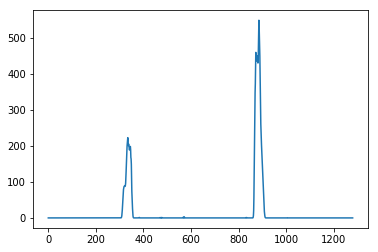

In [8]:
histogram = np.sum(warped_image_binary[warped_image_binary.shape[0]//2:,:], axis=0)
plt.plot(histogram)

## Implement Sliding Windows and Fit a Polynomial

In [9]:
# Assuming you have created a warped binary image called "binary_warped"
# Create an output image to draw on and  visualize the result
binary_warped = warped_image_binary
out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
# Find the peak of the left and right halves of the histogram
# These will be the starting point for the left and right lines
midpoint = np.int(histogram.shape[0]/2)
leftx_base = np.argmax(histogram[:midpoint])
rightx_base = np.argmax(histogram[midpoint:]) + midpoint

# Choose the number of sliding windows
nwindows = 9
# Set height of windows
window_height = np.int(binary_warped.shape[0]/nwindows)
# Identify the x and y positions of all nonzero pixels in the image
nonzero = binary_warped.nonzero()
nonzeroy = np.array(nonzero[0])
nonzerox = np.array(nonzero[1])
# Current positions to be updated for each window
leftx_current = leftx_base
rightx_current = rightx_base
# Set the width of the windows +/- margin
margin = 100
# Set minimum number of pixels found to recenter window
minpix = 50
# Create empty lists to receive left and right lane pixel indices
left_lane_inds = []
right_lane_inds = []

# Step through the windows one by one
for window in range(nwindows):
    # Identify window boundaries in x and y (and right and left)
    win_y_low = binary_warped.shape[0] - (window+1)*window_height
    win_y_high = binary_warped.shape[0] - window*window_height
    win_xleft_low = leftx_current - margin
    win_xleft_high = leftx_current + margin
    win_xright_low = rightx_current - margin
    win_xright_high = rightx_current + margin
    # Draw the windows on the visualization image
    cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high),
    (0,25,0), 3) 
    cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high),
    (0,25,0), 3) 
    # Identify the nonzero pixels in x and y within the window
    good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
    (nonzerox >= win_xleft_low) &  (nonzerox < win_xleft_high)).nonzero()[0]
    good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
    (nonzerox >= win_xright_low) &  (nonzerox < win_xright_high)).nonzero()[0]
    # Append these indices to the lists
    left_lane_inds.append(good_left_inds)
    right_lane_inds.append(good_right_inds)
    # If you found > minpix pixels, recenter next window on their mean position
    if len(good_left_inds) > minpix:
        leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
    if len(good_right_inds) > minpix:        
        rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

# Concatenate the arrays of indices
left_lane_inds = np.concatenate(left_lane_inds)
right_lane_inds = np.concatenate(right_lane_inds)

# Extract left and right line pixel positions
leftx = nonzerox[left_lane_inds]
lefty = nonzeroy[left_lane_inds] 
rightx = nonzerox[right_lane_inds]
righty = nonzeroy[right_lane_inds] 

# Fit a second order polynomial to each
left_fit = np.polyfit(lefty, leftx, 2)
right_fit = np.polyfit(righty, rightx, 2)

(720, 0)

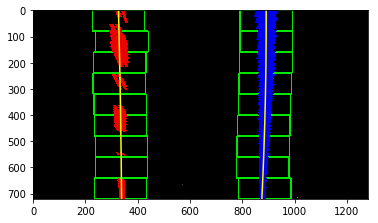

In [10]:
# Generate x and y values for plotting
ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [20, 0, 0]
out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 20]
plt.imshow(out_img)
plt.plot(left_fitx, ploty, color='yellow')
plt.plot(right_fitx, ploty, color='yellow')
plt.xlim(0, 1280)
plt.ylim(720, 0)

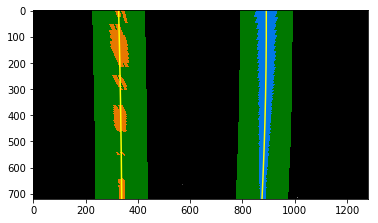

In [11]:
# Create an image to draw on and an image to show the selection window
out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
window_img = np.zeros_like(out_img)
# Color in left and right line pixels
out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [25, 0, 0]
out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 25]

# Generate a polygon to illustrate the search window area
# And recast the x and y points into usable format for cv2.fillPoly()
left_line_window1 = np.array([np.transpose(np.vstack([left_fitx-margin, ploty]))])
left_line_window2 = np.array([np.flipud(np.transpose(np.vstack([left_fitx+margin, 
                              ploty])))])
left_line_pts = np.hstack((left_line_window1, left_line_window2))
right_line_window1 = np.array([np.transpose(np.vstack([right_fitx-margin, ploty]))])
right_line_window2 = np.array([np.flipud(np.transpose(np.vstack([right_fitx+margin, 
                              ploty])))])
right_line_pts = np.hstack((right_line_window1, right_line_window2))

# Draw the lane onto the warped blank image
cv2.fillPoly(window_img, np.int_([left_line_pts]), (0,25, 0))
cv2.fillPoly(window_img, np.int_([right_line_pts]), (0,25, 0))
result = cv2.addWeighted(out_img, 1, window_img, 0.3, 0)
plt.imshow(result)
plt.plot(left_fitx, ploty, color='yellow')
plt.plot(right_fitx, ploty, color='yellow')

## Measuring the curvature

In [12]:
y_eval = image.shape[0]
left_curverad = ((1 + (2*left_fit[0]*y_eval + left_fit[1])**2)**1.5) / np.absolute(2*left_fit[0])
right_curverad = ((1 + (2*right_fit[0]*y_eval + right_fit[1])**2)**1.5) / np.absolute(2*right_fit[0])
print(left_curverad, right_curverad)

41032.0122099 13835.4266963


In [13]:
# Define conversions in x and y from pixels space to meters
ym_per_pix = 30/720 # meters per pixel in y dimension
xm_per_pix = 3.7/(int(min(right_fitx)-min(left_fitx))) # meters per pixel in x dimension

# Fit new polynomials to x,y in world space
left_fit_cr = np.polyfit(lefty*ym_per_pix, leftx*xm_per_pix, 2)
right_fit_cr = np.polyfit(righty*ym_per_pix, rightx*xm_per_pix, 2)
# Calculate the new radii of curvature
left_curverad = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
right_curverad = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])
# Now our radius of curvature is in meters
print(left_curverad, 'm', right_curverad, 'm')

10549.7725947 m 3545.12252864 m


## Unwarp and Drawing

True

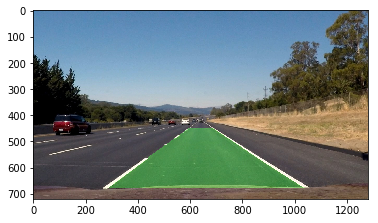

In [14]:
# Create an image to draw the lines on
warped = binary_warped
warp_zero = np.zeros_like(warped).astype(np.uint8)
color_warp = np.dstack((warp_zero, warp_zero, warp_zero))

# Recast the x and y points into usable format for cv2.fillPoly()
pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
pts = np.hstack((pts_left, pts_right))

# Draw the lane onto the warped blank image
cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))

# Invert the M matrix
Minv = np.linalg.inv(M)
# Warp the blank back to original image space using inverse perspective matrix (Minv)
newwarp = cv2.warpPerspective(color_warp, Minv, (image.shape[1], image.shape[0])) 
# Combine the result with the original image
result = cv2.addWeighted(image, 1, newwarp, 0.3, 0)
result_RGB = cv2.cvtColor(result,cv2.COLOR_BGR2RGB)
plt.imshow(result_RGB)
cv2.imwrite('output_images/'+input_image+'_processed.jpg', result)

## Video Processing

In [22]:
# Video Image Processing Pipeline
global s_thresh, sx_thresh, mtx, dist
def process_image(image):
    img_size = (image.shape[1], image.shape[0])
    # Apply the color and sobel gradients
    color_binary = thsd_enfs_pipeline(image, s_thresh, sx_thresh, mtx, dist)
    
    # Apply the perspective transformation
    warped_image_binary, M = pers_trans(color_binary, src, offset, img_size)
    
    # Create binary_image
    warped_image_binary = np.sum(warped_image_binary,axis=2)
    
    # Remove irrelevent information 
    warped_image_binary[:,0:200]=0
    warped_image_binary[:,1100:]=0
    
    # Find the peaks
    histogram = np.sum(warped_image_binary[warped_image_binary.shape[0]//2:,:], axis=0)
    binary_warped = warped_image_binary
    
    # Create an output image to draw on and  visualize the result
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
    
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]/2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint
    
    # Choose the number of sliding windows
    nwindows = 9
    # Set height of windows
    window_height = np.int(binary_warped.shape[0]/nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Current positions to be updated for each window
    leftx_current = leftx_base
    rightx_current = rightx_base
    # Set the width of the windows +/- margin
    margin = 100
    # Set minimum number of pixels found to recenter window
    minpix = 50
    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []

    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = binary_warped.shape[0] - (window+1)*window_height
        win_y_high = binary_warped.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        # Draw the windows on the visualization image
        cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high),
        (0,25,0), 3) 
        cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high),
        (0,25,0), 3) 
        # Identify the nonzero pixels in x and y within the window
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xleft_low) &  (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xright_low) &  (nonzerox < win_xright_high)).nonzero()[0]
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

    # Concatenate the arrays of indices
    left_lane_inds = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds] 

    # Fit a second order polynomial to each
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    # Measuring the curvature
    # Define conversions in x and y from pixels space to meters
    ym_per_pix = 30/720 # meters per pixel in y dimension
    xm_per_pix = 3.7/680 # meters per pixel in x dimension
    y_eval = image.shape[0]
    
    # Fit new polynomials to x,y in world space
    left_fit_cr = np.polyfit(lefty*ym_per_pix, leftx*xm_per_pix, 2)
    right_fit_cr = np.polyfit(righty*ym_per_pix, rightx*xm_per_pix, 2)
    # Calculate the new radii of curvature
    left_curverad = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
    right_curverad = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])
    # Create an image to draw the lines on
    warped = binary_warped
    warp_zero = np.zeros_like(warped).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))

    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))

    # Invert the M matrix
    Minv = np.linalg.inv(M)
    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    newwarp = cv2.warpPerspective(color_warp, Minv, (image.shape[1], image.shape[0])) 
    # Combine the result with the original image
    result = cv2.addWeighted(image, 1, newwarp, 0.3, 0)
    return result

In [24]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML
challenge_output = 'output_videos/project_video_processed.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
clip3 = VideoFileClip('project_video.mp4')
#clip3 = VideoFileClip('test_videos/challenge.mp4')
challenge_clip = clip3.fl_image(process_image)
%time challenge_clip.write_videofile(challenge_output, audio=False)


[MoviePy] >>>> Building video output_videos/project_video_processed.mp4
[MoviePy] Writing video output_videos/project_video_processed.mp4


100%|█████████████████████████████████████████████████████████████████████████████▉| 1260/1261 [04:48<00:00,  4.36it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: output_videos/project_video_processed.mp4 

Wall time: 4min 49s
